

# Hierarchical Risk Parity

Building profitable portfolios has been giving investment managers headaches for decades. Many approaches have been used up until now, some of the most well-known being Markowitz’s Efficient Frontier 

The development of this methodology is motivated by some issues regarding widely used strategies, such as Markowitz’s dependency on quadratic optimization of forecasted returns, frequently providing unstable and highly concentrated solutions.

In order to address these issues, aforementioned methodology proposes to:

* Drop forecasted returns and rely completely on covariance data.
* Cluster assets based on correlation in order to allocate less weight to similar assets.

In this approach, once the assets are hierarchically clustered, we a simple and efficient capital allocation within and across clusters of assets, so that many correlated assets receive the same total allocation as a single uncorrelated one. 

In this jupyter notebook:
* Compare the portfolio allocation against the hierarchial clustering based allocation
* Compare the out of the sample result of the portfolio against the hierarchial clustering based allocation
* Data Loading Cleaning etc are same as other notebooks.
* Model Development is presented is more details in the case studies. 

We will look at the Hierarchical Clustering (Agglomerative Clustering) Technique:



## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#5)        
    * [5.1. k-Means Clustering](#5.1)
        * [5.1.1 Finding right number of clusters](#5.1.1)
    * [5.2. Hierarchial Clustering (Agglomerative Clustering)](#5.2)
        * [5.2.1 Visualising the hierarchy](#5.2.1) 
    * [5.3. Affinity Propagation Clustering](#5.3)
        * [5.3.1 Visualising the cluster](#5.2.1) 
    * [5.4. DBSCAN Clustering](#5.4)
        * [5.3.1 Finding the right parameters](#5.4.1) 

<a id='0'></a>
# 1. Introduction

The 'Hierarchical Risk Parity' is a method to perform asset allocation without the need to invert a covariance matrix. It essentially computes a hierarchical tree (using a standard hierarchical clustering algorithm) from the correlation matrix, and then diversifies accross the different clusters.

We will proceed as follow:

* We get time series from the stock and bond data 
* We build an artificial correlation matrix C with several hierarchical clusters
* We transform C into a covariance matrix Sigma
* We apply the Hierarchical Risk Parity on these time series

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [513]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
import ffn

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
## 2.2. Loading the Data

In [514]:
# load dataset
dataset = read_csv('SP500Data.csv',index_col=0)

In [515]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [516]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [517]:
# shape
dataset.shape

(448, 502)

In [518]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.79,98.41,192.49,153.84,64.31,177.70,10.98,106.09,10.88,203.04,...,146.99,164.30,47.81,29.37,67.88,68.07,81.60,124.06,50.70,71.77
2018-01-03,58.92,99.95,195.82,154.55,65.31,181.04,11.55,107.05,10.87,202.12,...,149.74,162.52,47.49,29.33,69.24,68.90,81.53,124.92,50.64,72.10
2018-01-04,58.82,99.38,199.25,156.38,64.66,183.22,12.12,111.00,10.83,198.54,...,151.26,163.40,47.12,29.69,70.49,69.36,82.36,124.74,50.85,72.53
2018-01-05,58.99,101.11,202.32,157.67,66.37,185.34,11.88,112.18,10.87,199.47,...,152.23,164.49,46.79,29.91,74.15,69.23,82.84,125.98,50.87,73.36
2018-01-08,58.82,99.49,207.80,158.93,66.63,185.04,12.28,111.39,10.87,200.53,...,151.41,162.30,47.14,30.26,74.64,69.48,82.98,126.22,50.62,74.24


<a id='2.2'></a>
## 3.2. Data Visualization

We will look at the data visualisation in the later sections.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [519]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(448, 502)

Getting rid of the columns with more than 30% missing values. 

In [520]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(448, 498)

Given that there are null values drop the rown contianing the null values.

In [521]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.79,98.41,192.49,153.84,64.31,177.70,10.98,106.09,10.88,203.04,...,146.99,164.30,47.81,29.37,67.88,68.07,81.60,124.06,50.70,71.77
2018-01-03,58.92,99.95,195.82,154.55,65.31,181.04,11.55,107.05,10.87,202.12,...,149.74,162.52,47.49,29.33,69.24,68.90,81.53,124.92,50.64,72.10


<a id='3.2'></a>
## 4.2. Data Transformation

The decision is to use returns of the stock performance and its volatility. Hence, preparing the data for the Hierarchial Risk Partiy.

Defining 20% of the data as the test set

In [522]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [523]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [524]:
#Calculate percentage return 
returns = X_train.to_returns().dropna()
returns_test=X_test.to_returns().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='5.1'></a>
## 5.1. Building Hierarchy Graph/ Dendogram

The first step is to look for clusters of correlations using the agglomerate hierarchical clustering technique. 
The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

There are also different options for the measurement of the distance. The option we will choose is the average distance measurement, but others are possible (ward, single, centroid, etc.).


#### Compute Correlation

In [525]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [526]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([24.        , 25.        ,  0.09110116,  2.        ])

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

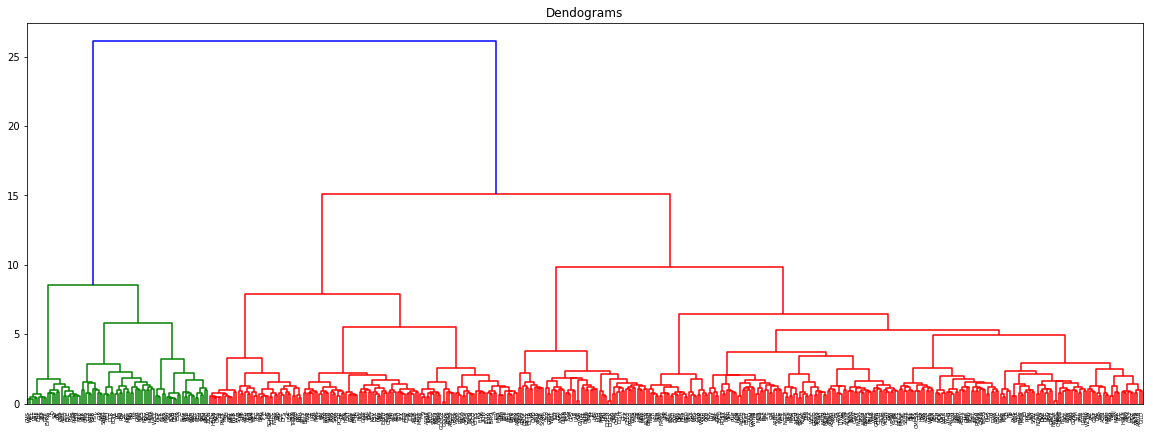

In [527]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendograms")
dendrogram(link,labels = X.columns)
plt.show()

<a id='5.2'></a>
### 5.2 Steps for Hierarchial Risk Parity

#### Step 1. Quasi-diagonalization and getting the weights for Hierarchial Risk Parity


A 'quasi-diagonalization' is a process usually known as matrix seriation and which can be performed using hierarchical clustering.
This process reorganize the covariance matrix so similar investments will be placed together. This matrix diagonalization allow us to distribute weights optimally following an inverse-variance allocation.

In [528]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Step 2:  Recursive bisection

 This step distribute the allocation through recursive bisection based on cluster covariance.

In [529]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Step 3:  Getting the portfolio weights

Following methods are used:

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. IVP - Naive Inverse-Variance Portfolio (which is allocating in the ratio of 1 / volatility)
    3. HRP - Hierarchial Risk Parity

In [530]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)


def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp



def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Step 4:  Getting the portfolio weights for all types of asset allocation

In [531]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [532]:
portfolios = get_all_portfolios(returns)
# portfolios
# portfolios.style.format({
#     'MVP': '{:,.2%}'.format,
#     'IVP': '{:,.2%}'.format,
#     'HRP': '{:,.2%}'.format,
# })

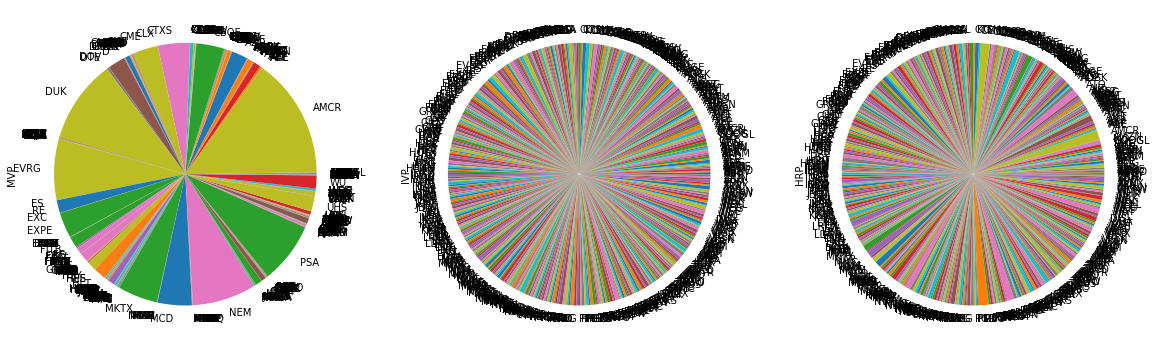

In [533]:
portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

**Clearly there is more diversitification in HRP as compated to MVP**

<a id='5'></a>
# 6. Backtesting-Out Of Sample 

In [534]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'IVP','HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'IVP','HRP'], index = returns_test.index)

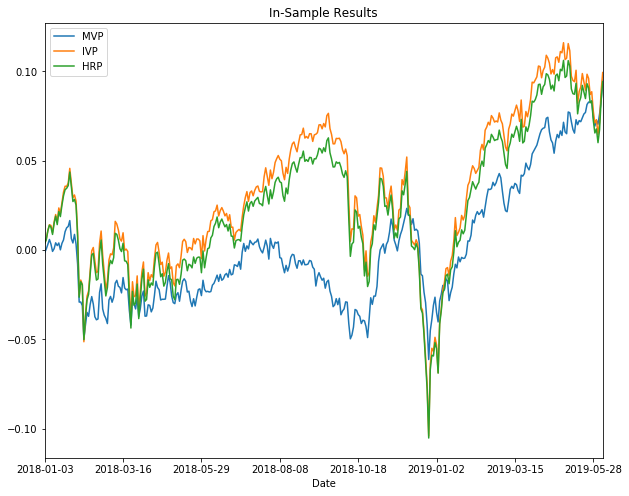

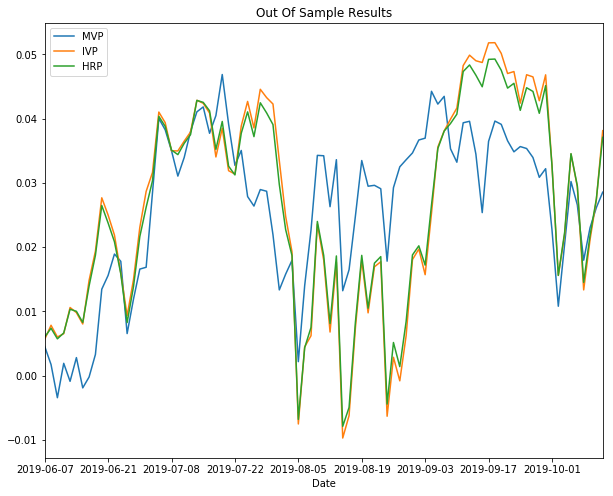

In [535]:
Insample_Result.cumsum().plot(figsize=(10, 8), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 8), title ="Out Of Sample Results")

### In Sample and Out of Sample Results

In [536]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.086,0.785
IVP,0.133,0.526
HRP,0.127,0.524


In [537]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.103,0.787
IVP,0.131,0.822
HRP,0.126,0.836


Although the insample results of MVP looks good, but out of sample sharp ratio and overall retun of Portfolio constructed using Hierarchial Clustering Approach is higher as compared to the Minimum-Variance Portfolio.

**Conclusion**

* Although MVP provides the optimal solution on in-sample data, evidence shown above suggests that a HRP portfolio can outperform in out-of-sample.This will achieve superior risk-adjusted returns than other traditional methods.

* As we can extract from the asset allocation, tradition in MVP the allocation is less diverse and is concentrated in the few stocks, while in HPR the concentration is more diverse and distributed across many asset classes. On the other hand, IVP evenly spreads weights through all assets, ignoring the correlation structure.The diversification that HRP achieves across uncorrelated assets makes the methodology more robust against shocks. 